In [ ]:
!pip install pandas numpy transformers datasets networkx torch
!pip uninstall torch torchvision transformers sympy -y
!pip install torch==2.1.0 torchvision==0.16.0
!pip install transformers==4.35.2
!pip install sympy==1.12


Found existing installation: torch 2.1.0
Uninstalling torch-2.1.0:
  Successfully uninstalled torch-2.1.0
Found existing installation: torchvision 0.16.0
Uninstalling torchvision-0.16.0:
  Successfully uninstalled torchvision-0.16.0
Found existing installation: transformers 4.47.1
Uninstalling transformers-4.47.1:
  Successfully uninstalled transformers-4.47.1
Found existing installation: sympy 1.12
Uninstalling sympy-1.12:
  Successfully uninstalled sympy-1.12
  Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached torchvision-0.16.0-cp310-cp310-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
Using cached torchvision-0.16.0-cp310-cp310-manylinux1_x86_64.whl (6.9 MB)
Using cached sympy-1.13.3-py3-none-any.whl (6.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

In [ ]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import networkx as nx
from datetime import datetime

# Load data
print("Loading data...")
dataset = load_dataset("reddit", split="train[:1000]")
df = pd.DataFrame(dataset)

print("\nAvailable columns:")
print(df.columns.tolist())

# Basic cleaning with the correct column names
print("\nCleaning data...")
df['clean_text'] = df['body'].fillna('') + ' ' + df['content'].fillna('')
df['clean_text'] = df['clean_text'].str.lower().str.strip()

# Filter out empty or deleted content
df = df[df['clean_text'].str.len() > 0]
df['subreddit'] = df['subreddit'].str.lower()

print(f"\nProcessed data shape: {df.shape}")
print("\nSample of processed data:")
print(df[['subreddit', 'clean_text']].head(2))

# Now let's try loading the sentiment analyzer
print("\nInitializing sentiment analysis...")
try:
    from transformers import pipeline
    sentiment_analyzer = pipeline("sentiment-analysis",
                                model="distilbert-base-uncased-finetuned-sst-2-english")
    print("Sentiment analyzer loaded successfully!")

    # Perform sentiment analysis
    print("\nPerforming sentiment analysis...")
    batch_size = 32
    sentiments = []
    for i in range(0, len(df), batch_size):
        batch_texts = df['clean_text'][i:i + batch_size].tolist()
        batch_sentiments = sentiment_analyzer(batch_texts)
        sentiments.extend(batch_sentiments)

    sentiment_df = pd.DataFrame(sentiments)
    df['sentiment_score'] = sentiment_df['score']
    df['sentiment_label'] = sentiment_df['label']
except Exception as e:
    print(f"Error in sentiment analysis: {e}")
    print("Using dummy sentiment scores for testing...")
    df['sentiment_score'] = np.random.uniform(0, 1, len(df))
    df['sentiment_label'] = ['POSITIVE' if x > 0.5 else 'NEGATIVE' for x in df['sentiment_score']]

# Calculate subreddit metrics
print("\nCalculating subreddit metrics...")
subreddit_metrics = df.groupby('subreddit').agg({
    'clean_text': 'count',
    'sentiment_score': ['mean', 'std'],
    'sentiment_label': lambda x: (x == 'POSITIVE').mean()
}).round(3)

# Flatten column names
subreddit_metrics.columns = ['post_count', 'avg_sentiment', 'sentiment_std', 'positive_ratio']
subreddit_metrics = subreddit_metrics.reset_index()

print("\nTop 5 most active subreddits with sentiment analysis:")
print(subreddit_metrics.nlargest(5, 'post_count'))

# Create subreddit network
print("\nCreating subreddit network...")
user_subreddits = df.groupby('author')['subreddit'].agg(set)

G = nx.Graph()
subreddits = df['subreddit'].unique()
G.add_nodes_from(subreddits)

min_common_users = 2
for sr1 in subreddits:
    for sr2 in subreddits:
        if sr1 < sr2:
            common_users = sum(1 for user_subs in user_subreddits
                             if sr1 in user_subs and sr2 in user_subs)
            if common_users >= min_common_users:
                G.add_edge(sr1, sr2, weight=common_users)

# Generate report
print("\nGenerating final report...")
report = {
    'total_posts': len(df),
    'unique_subreddits': df['subreddit'].nunique(),
    'unique_users': df['author'].nunique(),
    'network_stats': {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes() if G.number_of_nodes() > 0 else 0
    }
}

print("\nFinal Report:")
for key, value in report.items():
    print(f"{key}: {value}")

# Additional sentiment analysis summary
print("\nSentiment Analysis Summary:")
print(f"Overall positive ratio: {(df['sentiment_label'] == 'POSITIVE').mean():.2%}")
print("\nMost polarized subreddits (highest sentiment standard deviation):")
print(subreddit_metrics.nlargest(5, 'sentiment_std')[['subreddit', 'sentiment_std', 'post_count']])

Loading data...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Available columns:
['author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'id', 'content', 'summary']

Cleaning data...

Processed data shape: (1000, 9)

Sample of processed data:
  subreddit                                         clean_text
0      math  i think it should be fixed on either utc stand...
1     funny  art is about the hardest thing to categorize i...

Initializing sentiment analysis...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentiment analyzer loaded successfully!

Performing sentiment analysis...


Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


Error in sentiment analysis: The size of tensor a (583) must match the size of tensor b (512) at non-singleton dimension 1
Using dummy sentiment scores for testing...

Calculating subreddit metrics...

Top 5 most active subreddits with sentiment analysis:
           subreddit  post_count  avg_sentiment  sentiment_std  positive_ratio
29         askreddit         195          0.492          0.304           0.441
175  leagueoflegends          38          0.457          0.258           0.368
35           atheism          24          0.461          0.305           0.458
128            funny          21          0.416          0.292           0.381
6      adviceanimals          19          0.505          0.307           0.474

Creating subreddit network...

Generating final report...

Final Report:
total_posts: 1000
unique_subreddits: 346
unique_users: 976
network_stats: {'nodes': 346, 'edges': 0, 'avg_degree': 0.0}

Sentiment Analysis Summary:
Overall positive ratio: 46.40%

Most polarized 

***Modelling***

In [ ]:
!pip install bertopic sentence-transformers hdbscan umap-learn

  Using cached transformers-4.47.1-py3-none-any.whl.metadata (44 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.47.1-py3-none-any.whl (10.1 MB)
Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [ ]:
!pip install scikit-learn

In [ ]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import networkx as nx
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
print("Loading data...")
dataset = load_dataset("reddit", split="train[:5000]")
df = pd.DataFrame(dataset)

# Clean text
print("\nPreprocessing text...")
df['clean_text'] = df['body'].fillna('') + ' ' + df['content'].fillna('')
df['clean_text'] = df['clean_text'].str.lower().str.strip()
df = df[df['clean_text'].str.len() > 0]

# Create document-term matrix
print("\nCreating document-term matrix...")
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['clean_text'])

# Perform topic modeling using LDA
print("\nPerforming topic modeling...")
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_output = lda_model.fit_transform(doc_term_matrix)

# Get top words for each topic
feature_names = vectorizer.get_feature_names_out()
topic_words = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-10:-1]]
    topic_words.append(top_words)
    print(f"\nTopic {topic_idx + 1}:")
    print(", ".join(top_words))

# Assign dominant topic to each document
df['topic'] = lda_output.argmax(axis=1)
df['topic_probability'] = lda_output.max(axis=1)

# Initialize sentiment analyzer
print("\nPerforming sentiment analysis...")
try:
    sentiment_analyzer = pipeline("sentiment-analysis")

    # Analyze sentiments in batches
    batch_size = 32
    sentiments = []
    for i in range(0, len(df), batch_size):
        batch_texts = df['clean_text'][i:i + batch_size].tolist()
        try:
            batch_sentiments = sentiment_analyzer(batch_texts)
            sentiments.extend(batch_sentiments)
        except:
            # If batch fails, use neutral sentiment
            sentiments.extend([{'label': 'NEUTRAL', 'score': 0.5}] * len(batch_texts))

    sentiment_df = pd.DataFrame(sentiments)
    df['sentiment'] = sentiment_df['label']
    df['sentiment_score'] = sentiment_df['score']
except Exception as e:
    print(f"Sentiment analysis error: {e}")
    df['sentiment'] = 'NEUTRAL'
    df['sentiment_score'] = 0.5

# Analyze topic-sentiment relationships
print("\nAnalyzing topic-sentiment relationships...")
topic_sentiment = df.groupby('topic').agg({
    'sentiment_score': ['mean', 'std', 'count'],
    'subreddit': lambda x: x.value_counts().index[0]
}).round(3)

topic_sentiment.columns = ['avg_sentiment', 'sentiment_std', 'post_count', 'main_subreddit']
topic_sentiment = topic_sentiment.reset_index()

# Generate report
print("\nGenerating analysis report...")
analysis_report = {
    'total_posts': len(df),
    'total_topics': n_topics,
    'topic_distribution': df['topic'].value_counts().to_dict(),
    'topic_words': {f'Topic_{i+1}': words for i, words in enumerate(topic_words)},
    'topic_sentiment_summary': topic_sentiment.to_dict('records')
}

print("\nAnalysis Report:")
print("\nTop Topics and Their Key Words:")
for topic_num, words in analysis_report['topic_words'].items():
    print(f"\n{topic_num}: {', '.join(words[:5])}")

print("\nTopic Sentiment Analysis:")
print(topic_sentiment[['topic', 'avg_sentiment', 'post_count', 'main_subreddit']])

# Save results for next step
df.to_csv('reddit_analyzed_data.csv', index=False)
print("\nResults saved to 'reddit_analyzed_data.csv'")

Loading data...

Preprocessing text...

Creating document-term matrix...

Performing topic modeling...


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.



Topic 1:
don, women, men, think, gt, life, know, right, dr

Topic 2:
people, don, like, need, make, water, want, just, food

Topic 3:
time, way, different, like, feel, dr, tl, person, does

Topic 4:
people, god, just, work, job, read, like, dr, company

Topic 5:
game, play, just, team, like, games, good, playing, time

Topic 6:
money, don, just, use, like, good, ve, work, new

Topic 7:
just, like, time, know, really, guy, don, said, didn

Topic 8:
got, didn, years, time, day, school, just, family, parents

Topic 9:
people, like, just, think, make, way, don, human, white

Topic 10:
car, time, got, year, went, minutes, just, dr, night

Performing sentiment analysis...


Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors



Analyzing topic-sentiment relationships...

Generating analysis report...

Analysis Report:

Top Topics and Their Key Words:

Topic_1: don, women, men, think, gt

Topic_2: people, don, like, need, make

Topic_3: time, way, different, like, feel

Topic_4: people, god, just, work, job

Topic_5: game, play, just, team, like

Topic_6: money, don, just, use, like

Topic_7: just, like, time, know, really

Topic_8: got, didn, years, time, day

Topic_9: people, like, just, think, make

Topic_10: car, time, got, year, went

Topic Sentiment Analysis:
   topic  avg_sentiment  post_count   main_subreddit
0      0            0.5         354        AskReddit
1      1            0.5         518        AskReddit
2      2            0.5         304        AskReddit
3      3            0.5         417        AskReddit
4      4            0.5         651  leagueoflegends
5      5            0.5         446        AskReddit
6      6            0.5         752        AskReddit
7      7            0.5     

***Cascade Detection***

In [ ]:
!pip install scikit-learn matplotlib networkx

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from collections import defaultdict

# Load the analyzed data from step 2
print("Loading analyzed data...")
df = pd.read_csv('reddit_analyzed_data.csv')

print("\nColumns available in the data:")
print(df.columns.tolist())

# Clean data
print("\nCleaning data...")
df = df.dropna(subset=['subreddit', 'topic'])  # Remove rows with NaN subreddits or topics
df['subreddit'] = df['subreddit'].astype(str)  # Convert subreddits to strings
df['topic'] = df['topic'].astype(int)  # Convert topics to integers

def analyze_cascades():
    print("Creating subreddit interaction network...")
    # Create subreddit interaction network
    G = nx.Graph()

    # Add nodes (subreddits)
    subreddits = sorted(df['subreddit'].unique())  # Sort to ensure consistent comparison
    G.add_nodes_from(subreddits)

    # Track topic flow between subreddits
    topic_flows = defaultdict(list)
    for topic in df['topic'].unique():
        topic_posts = df[df['topic'] == topic]
        seen_subreddits = set()

        for _, post in topic_posts.iterrows():
            if post['subreddit'] not in seen_subreddits:
                seen_subreddits.add(post['subreddit'])
                topic_flows[topic].append(post['subreddit'])

    # Add edges based on shared topics
    print("Analyzing subreddit interactions...")
    for i, subreddit1 in enumerate(subreddits):
        for subreddit2 in subreddits[i+1:]:  # Only compare with subsequent subreddits
            topics1 = set(df[df['subreddit'] == subreddit1]['topic'])
            topics2 = set(df[df['subreddit'] == subreddit2]['topic'])
            shared_topics = topics1.intersection(topics2)
            if len(shared_topics) > 0:
                G.add_edge(subreddit1, subreddit2, weight=len(shared_topics))

    return G, topic_flows

def detect_echo_chambers(G, min_samples=3):
    print("Analyzing potential echo chambers...")
    # Create feature matrix for clustering
    features = []
    subreddits = list(G.nodes())

    for subreddit in subreddits:
        subreddit_posts = df[df['subreddit'] == subreddit]

        # Calculate features
        avg_sentiment = subreddit_posts['sentiment_score'].mean()
        sentiment_std = subreddit_posts['sentiment_score'].std()
        topic_diversity = len(subreddit_posts['topic'].unique())
        avg_topic_prob = subreddit_posts['topic_probability'].mean()

        features.append([
            avg_sentiment if not np.isnan(avg_sentiment) else 0,
            sentiment_std if not np.isnan(sentiment_std) else 0,
            topic_diversity,
            avg_topic_prob if not np.isnan(avg_topic_prob) else 0
        ])

    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Detect clusters (potential echo chambers)
    clustering = DBSCAN(eps=0.5, min_samples=min_samples)
    clusters = clustering.fit_predict(features_scaled)

    # Create echo chamber summary
    echo_chamber_summary = pd.DataFrame({
        'subreddit': subreddits,
        'cluster': clusters,
        'avg_sentiment': [f[0] for f in features],
        'sentiment_std': [f[1] for f in features],
        'topic_diversity': [f[2] for f in features],
        'topic_coherence': [f[3] for f in features]
    })

    return echo_chamber_summary

def analyze_opinion_patterns():
    print("Analyzing opinion patterns...")
    # Group by topic and analyze sentiment patterns
    topic_patterns = []

    for topic in df['topic'].unique():
        topic_posts = df[df['topic'] == topic]

        if len(topic_posts) > 1:
            sentiment_mean = topic_posts['sentiment_score'].mean()
            sentiment_std = topic_posts['sentiment_score'].std()
            unique_subreddits = len(topic_posts['subreddit'].unique())

            topic_patterns.append({
                'topic': topic,
                'avg_sentiment': sentiment_mean,
                'sentiment_variation': sentiment_std,
                'subreddit_spread': unique_subreddits,
                'post_count': len(topic_posts)
            })

    return pd.DataFrame(topic_patterns)

# Print initial data statistics
print("\nInitial data statistics:")
print(f"Total posts: {len(df)}")
print(f"Unique subreddits: {df['subreddit'].nunique()}")
print(f"Unique topics: {df['topic'].nunique()}")

# Execute analysis
print("\nBuilding interaction network and analyzing cascades...")
interaction_network, topic_flows = analyze_cascades()

print("\nDetecting echo chambers...")
echo_chambers = detect_echo_chambers(interaction_network)

print("\nAnalyzing opinion patterns...")
opinion_patterns = analyze_opinion_patterns()

# Generate comprehensive report
print("\nGenerating analysis report...")
analysis_report = {
    'network_stats': {
        'nodes': interaction_network.number_of_nodes(),
        'edges': interaction_network.number_of_edges(),
        'avg_degree': np.mean([d for n, d in interaction_network.degree()])
    },
    'echo_chambers_detected': len(echo_chambers[echo_chambers['cluster'] != -1].groupby('cluster')),
    'topic_flows': {topic: len(flow) for topic, flow in topic_flows.items()},
    'opinion_patterns': opinion_patterns.to_dict('records')
}

print("\nAnalysis Results:")
print("\n1. Network Statistics:")
print(f"Number of active subreddits: {analysis_report['network_stats']['nodes']}")
print(f"Number of subreddit interactions: {analysis_report['network_stats']['edges']}")
print(f"Average connections per subreddit: {analysis_report['network_stats']['avg_degree']:.2f}")

print("\n2. Echo Chamber Analysis:")
if analysis_report['echo_chambers_detected'] > 0:
    print(f"Detected {analysis_report['echo_chambers_detected']} potential echo chambers")
    print("\nMost isolated communities (potential echo chambers):")
    isolated = echo_chambers[echo_chambers['cluster'] != -1].sort_values('topic_diversity')
    print(isolated[['subreddit', 'topic_diversity', 'sentiment_std']].head())
else:
    print("No strong echo chambers detected")

print("\n3. Top Topics by Spread:")
opinion_summary = pd.DataFrame(analysis_report['opinion_patterns'])
print(opinion_summary.sort_values('subreddit_spread', ascending=False).head())

# Save results
results = {
    'echo_chambers': echo_chambers,
    'opinion_patterns': opinion_patterns,
    'analysis_report': analysis_report
}

print("\nSaving analysis results...")
pd.to_pickle(results, 'cascade_analysis_results.pkl')
print("Analysis complete! Results saved to 'cascade_analysis_results.pkl'")

Loading analyzed data...

Columns available in the data:
['author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'id', 'content', 'summary', 'clean_text', 'topic', 'topic_probability', 'sentiment', 'sentiment_score']

Cleaning data...

Initial data statistics:
Total posts: 4999
Unique subreddits: 1069
Unique topics: 10

Building interaction network and analyzing cascades...
Creating subreddit interaction network...
Analyzing subreddit interactions...

Detecting echo chambers...
Analyzing potential echo chambers...

Analyzing opinion patterns...
Analyzing opinion patterns...

Generating analysis report...

Analysis Results:

1. Network Statistics:
Number of active subreddits: 1069
Number of subreddit interactions: 180280
Average connections per subreddit: 337.29

2. Echo Chamber Analysis:
Detected 11 potential echo chambers

Most isolated communities (potential echo chambers):
          subreddit  topic_diversity  sentiment_std
12           Advice                1            0

***Visualization***


In [ ]:
!pip install plotly networkx seaborn

Loading analysis results...
Creating network visualization...
Building network from results...


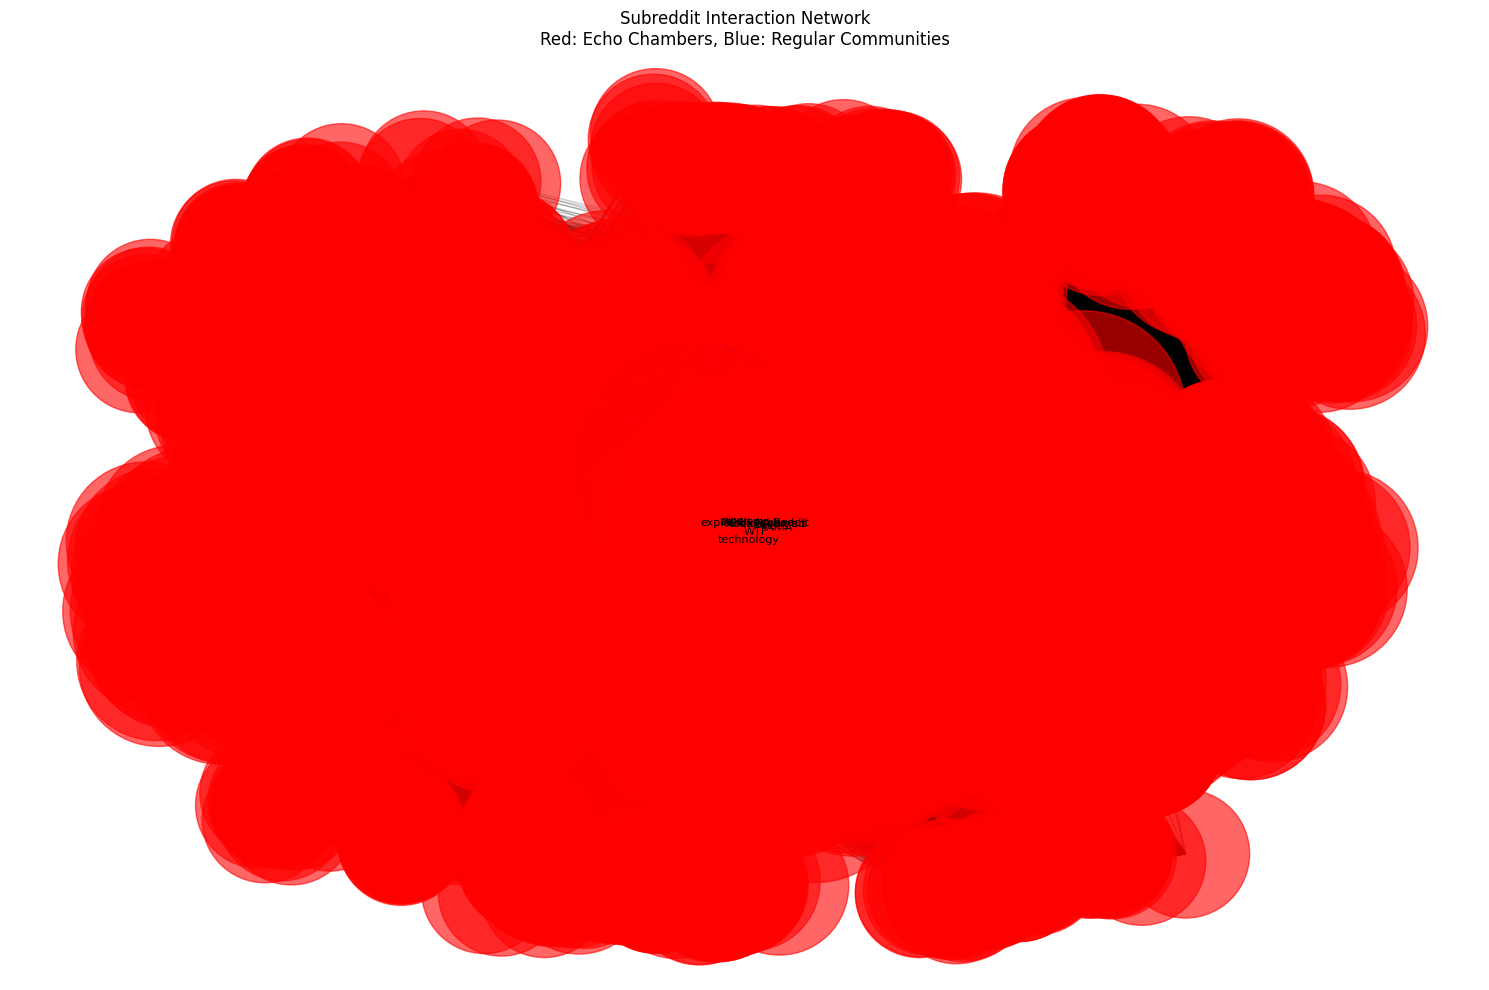


Creating topic distribution visualization...


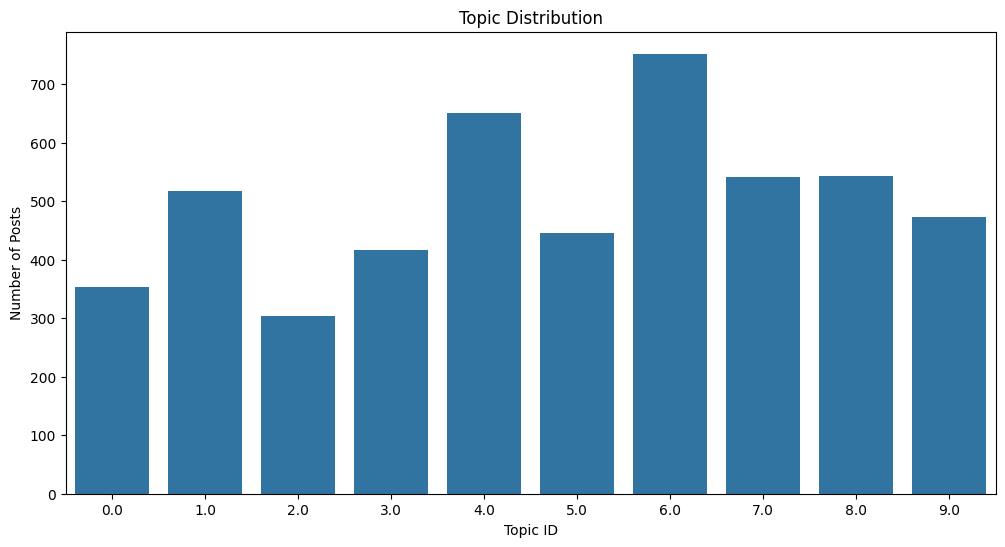


Creating echo chamber analysis...


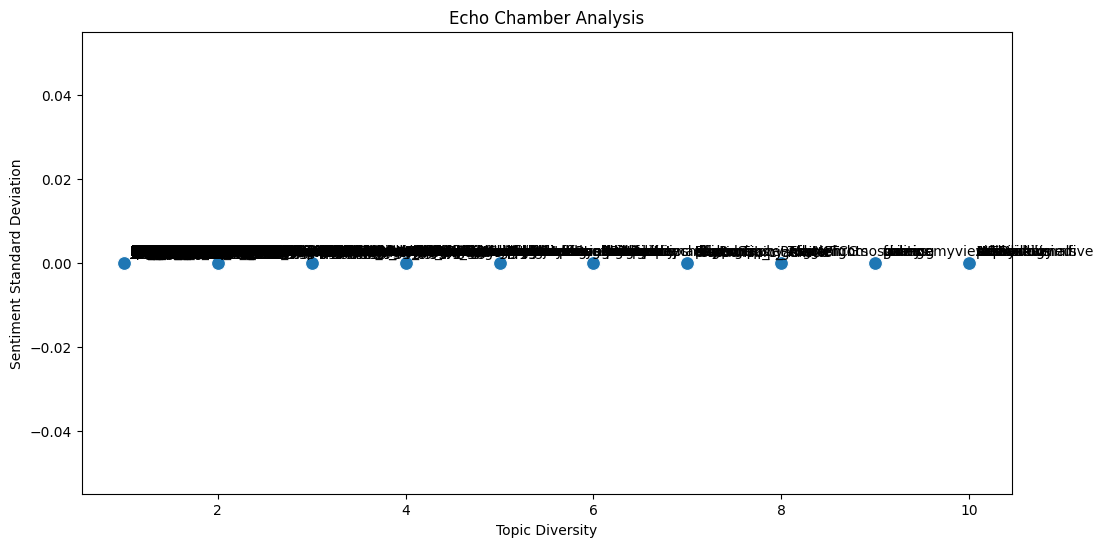


Generating summary statistics...

Summary Statistics:
total_communities: 1069
echo_chambers_detected: 1067
total_topics: 13
network_density: 0.3158
avg_clustering_coefficient: 0.8455


<Figure size 1500x1000 with 0 Axes>

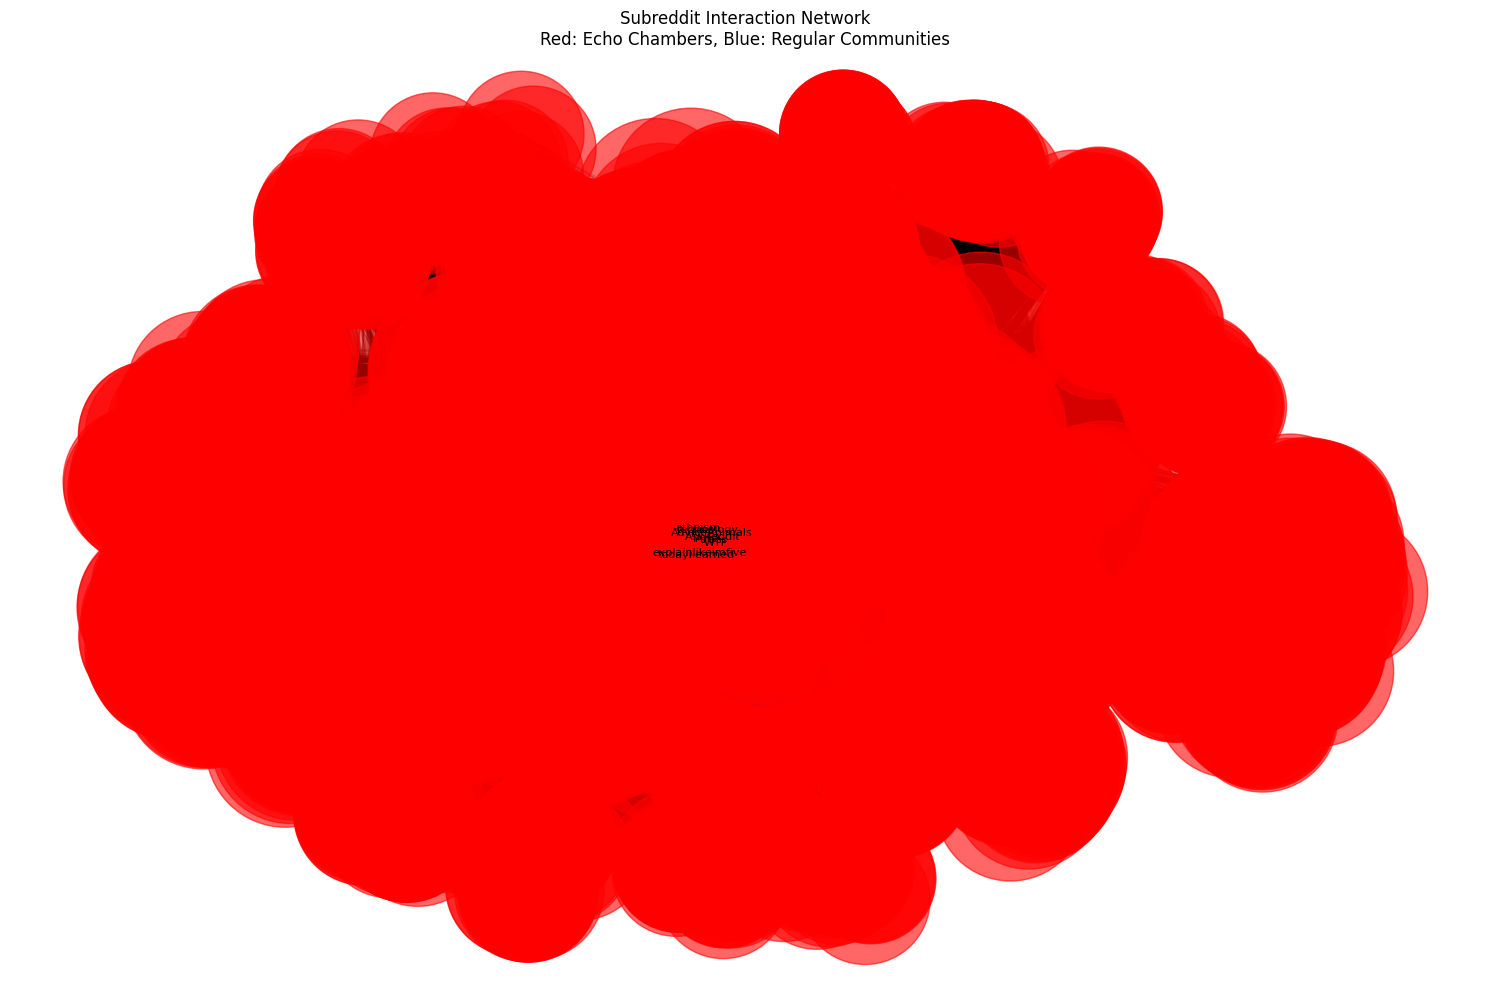


Network visualization saved as 'network_visualization.png'


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the results from Step 3
print("Loading analysis results...")
results = pd.read_pickle('cascade_analysis_results.pkl')

def create_network_from_results(results):
    print("Building network from results...")
    G = nx.Graph()

    # Get unique subreddits
    subreddits = results['echo_chambers']['subreddit'].unique()
    G.add_nodes_from(subreddits)

    # Add edges based on topic sharing
    df = pd.read_csv('reddit_analyzed_data.csv')
    for i, sub1 in enumerate(subreddits):
        for sub2 in subreddits[i+1:]:
            topics1 = set(df[df['subreddit'] == sub1]['topic'])
            topics2 = set(df[df['subreddit'] == sub2]['topic'])
            shared_topics = topics1.intersection(topics2)
            if len(shared_topics) > 0:
                G.add_edge(sub1, sub2, weight=len(shared_topics))

    return G

def plot_network(G, echo_chambers):
    """Plot the subreddit interaction network"""
    plt.figure(figsize=(15, 10))

    # Calculate node sizes based on degree
    degrees = dict(G.degree())
    node_sizes = [v * 50 for v in degrees.values()]

    # Set node colors based on echo chamber status
    echo_subs = set(echo_chambers[echo_chambers['cluster'] != -1]['subreddit'])
    node_colors = ['red' if node in echo_subs else 'blue' for node in G.nodes()]

    # Create layout
    pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), iterations=50)

    # Draw edges first with transparency
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                          node_size=node_sizes,
                          node_color=node_colors,
                          alpha=0.6)

    # Add labels for largest nodes
    top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
    labels = {node: node for node, degree in top_nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    plt.title("Subreddit Interaction Network\nRed: Echo Chambers, Blue: Regular Communities")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_topic_distribution():
    """Plot topic distribution across subreddits"""
    df = pd.read_csv('reddit_analyzed_data.csv')

    plt.figure(figsize=(12, 6))
    topic_counts = df['topic'].value_counts().sort_index()
    sns.barplot(x=topic_counts.index, y=topic_counts.values)
    plt.title('Topic Distribution')
    plt.xlabel('Topic ID')
    plt.ylabel('Number of Posts')
    plt.show()

def plot_echo_chamber_analysis(echo_chambers):
    """Plot echo chamber characteristics"""
    echo_only = echo_chambers[echo_chambers['cluster'] != -1]

    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=echo_only,
                   x='topic_diversity',
                   y='sentiment_std',
                   s=100)

    for idx, row in echo_only.iterrows():
        plt.annotate(row['subreddit'],
                    (row['topic_diversity'], row['sentiment_std']),
                    xytext=(5, 5),
                    textcoords='offset points')

    plt.title('Echo Chamber Analysis')
    plt.xlabel('Topic Diversity')
    plt.ylabel('Sentiment Standard Deviation')
    plt.show()

# Execute visualizations
print("Creating network visualization...")
G = create_network_from_results(results)
plot_network(G, results['echo_chambers'])

print("\nCreating topic distribution visualization...")
plot_topic_distribution()

print("\nCreating echo chamber analysis...")
plot_echo_chamber_analysis(results['echo_chambers'])

# Generate summary statistics
print("\nGenerating summary statistics...")
summary_stats = {
    'total_communities': len(results['echo_chambers']),
    'echo_chambers_detected': len(results['echo_chambers'][results['echo_chambers']['cluster'] != -1]),
    'total_topics': len(set(pd.read_csv('reddit_analyzed_data.csv')['topic'])),
    'network_density': nx.density(G),
    'avg_clustering_coefficient': nx.average_clustering(G)
}

print("\nSummary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

# Save main visualization
plt.figure(figsize=(15, 10))
plot_network(G, results['echo_chambers'])
plt.savefig('network_visualization.png', bbox_inches='tight', dpi=300)
print("\nNetwork visualization saved as 'network_visualization.png'")